# Face & landmark detection

Although Medusa's main focus is 3D/4D reconstruction, it also contains functionality for face detection, facial landmark prediction, and cropping as these steps often need to be performed before feeding images into reconstruction models.

In this tutorial, we will demonstrate these features.

## Face detection

The first step in many face analysis pipelines is _face detection_. Medusa contains two classes that perform face detection:

* `SCRFDetector`: a detection model based on InsightFace's SCRFD model `citep`{};
* `YunetDetector`: a detection model implemented in OpenCV

We recommend using the `SCRFDetector` as our experience is that it is substantially more accurate than `YunetDetector` (albeit a bit slower when run on CPU); if you want to use the `YunetDetector`, make sure to install OpenCV first (`pip install python-opencv`). So we'll use the `SCRFDetector` for the rest of this section.


In [18]:
from medusa.detect import SCRFDetector

Under the hood, `SCRFDetector` uses an ONNX model provided by InsightFace, but our implementation is quite a bit faster than the original InsightFace implementation as ours uses PyTorch throughout (rather than a mix of PyTorch and numpy).

The `SCRFDetector` takes the following inputs upon initialization:

* `det_size`: size to resize images to before passing to the detection model;
* `det_threshold`: minimum detection threshold (float between 0-1)
* `nms_threshold`: non-maximum suppression threshold (boxes overlapping more than this proportion are removed)
* `device`: either "cpu" or "cuda" (determined automatically by default)

The most important arguments are `det_size` and `det_threshold`; a higher `det_size` (a tuple with two integers, width x height) leads to potentially more accurate detections but slower processing; increasing `det_threshold` leads to more conservative detections (fewer false alarms, but more misses) and vice versa.

In our experience, the defaults are fine for most stimuli:

In [19]:
detector = SCRFDetector()

Now let's apply it to some example data. We'll use a single frame from out example video:

In [44]:
from medusa.data import get_example_frame

img = get_example_frame(load_torch=True)

Here, `img` represents is loaded as a PyTorch tensor, but the detectors in Medusa can deal with paths to images or numpy arrays, too. Now, to process this image with the detector, we'll call the `detector` object as if it is a function (which internally triggers the `__call__` method):

In [45]:
det = detector(img)

The output of the detector call, `det`, contains a dictionary with information:

In [46]:
det.keys()

dict_keys(['img_idx', 'conf', 'lms', 'bbox', 'n_img'])

Notably, all values of the dictionary are PyTorch tensors. The most important keys are:

* `conf`: the confidence of each detection (0-1)
* `lms`: a set of five landmark coordinates per detection
* `bbox`: a bounding box per detection

Let's take a look at `conf`:

In [47]:
conf = det['conf']
print(f"Conf: {conf.item():.3f}, shape: {tuple(conf.shape)}")

Conf: 0.884, shape: (1,)


So for this image, there is only one detection with a confidence of 0.884. Note that there may be more than one detection per image when there are more faces in the image! 

Let's also take a look at the bounding box for the detection:

In [66]:
det['bbox']

tensor([[187.4764,  20.0963, 414.5220, 337.8104]], device='cuda:0')

The bounding box contains four values (in pixel units) that represent the box' mimimum x-value, minimum y-value, maximum x-value, and maximum y-value (in that order). We can in fact visualize this bounding box quite straightforwardly using `torchvision`:

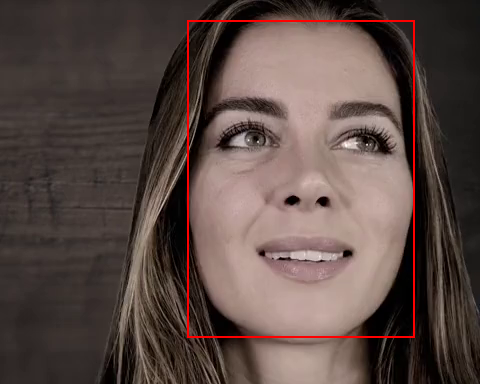

In [67]:
from IPython.display import Image
from torchvision.utils import draw_bounding_boxes, save_image

# Note that `draw_bounding_boxes` expects the img to be in C x H x W format
red = (255, 0, 0)
draw = draw_bounding_boxes(img.permute(2, 0, 1), det['bbox'], colors=red, width=2)

# Save image to disk and display in notebook
save_image(draw.float(), 'bbox.png', normalize=True)
Image('bbox.png')

Looks like a proper bounding box! Now, let's finally look at the predicted facial landmarks:

In [68]:
det['lms']

tensor([[[249.6934, 138.3164],
         [364.9851, 140.5700],
         [311.6084, 185.3770],
         [256.7564, 250.2902],
         [357.6646, 251.7064]]], device='cuda:0')

As you can see, each detection also comes with 5 landmarks consisting of two values (one for X, one for Y) in pixel units. As we'll show below (again, using `torchvision`), these landmarks refer to the left eye, right eye, tip of the nose, left mouthcorner, and right mouth corner:

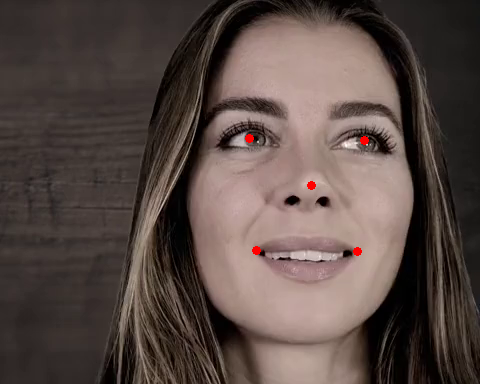

In [70]:
from torchvision.utils import draw_keypoints

# Note that `draw_keypoints` also expects the img to be in C x H x W format
draw = draw_keypoints(img.permute(2, 0, 1), det['lms'], colors=red, radius=4)

# Save image to disk and display in notebook
save_image(draw.float(), 'lms.png', normalize=True)
Image('lms.png')

Show video / batch stuff

In [15]:
from medusa.data import get_example_video
from medusa.detect import SCRFDetector
from medusa.io import VideoLoader

vid = get_example_video()
loader = VideoLoader(vid, batch_size=64)
batch = next(iter(loader))

detector = SCRFDetector()
out = detector(batch)

In [16]:
from medusa.containers import BatchResults
from IPython.display import Video

results = BatchResults(**out)
results.visualize('./test.mp4', batch, video=True, fps=24)

Video('./test.mp4', embed=True)

## Landmark detection

## Cropping